In [14]:
import sys
sys.path.append("../../XLEMOO")

In [88]:
from XLEMOO.LEMOO import EAParams, MLParams, LEMParams, LEMOO, PastGeneration
from XLEMOO.fitness_indicators import naive_sum, must_sum_to_one, asf_wrapper, single_objective, hypervolume_contribution
from XLEMOO.tree_interpreter import instantiate_tree_rules, find_all_paths
from XLEMOO.problems import river_pollution_problem
from XLEMOO.plotting import plot_best_fitnesses, plot_mean_fitnesses, plot_std_fitnesses, plot_hypervolume
from XLEMOO.selection import SelectNBest
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_emo.selection import TournamentSelection
from desdeo_problem.testproblems import test_problem_builder
from desdeo_tools.scalarization.ASF import SimpleASF, GuessASF, StomASF, PointMethodASF
from desdeo_tools.utilities import hypervolume_indicator, epsilon_indicator_ndims, fast_non_dominated_sort_indices
from typing import List

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np
from imodels import C45TreeClassifier, SlipperClassifier

## Define problem

In [153]:
n_objectives = 3
n_variables = 5
problem = test_problem_builder("DTLZ2", n_variables, n_objectives)
# problem = river_pollution_problem()

## Setting model parameters

In [154]:
nadir = np.ones(n_objectives)
ideal = np.zeros(n_objectives)
# ideal = np.array([-6.34, -3.44, -7.5, 0, 0])
# nadir = np.array([-4.75, -2.85, -0.32, 9.70, 0.35])
ref_point = np.array([0.3, 0.25, 0.65])
fitness_fun = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})

# fitness_fun = naive_sum
# fitness_fun = hypervolume_contribution(5*nadir)

lem_params = LEMParams(
    use_darwin=True,
    use_ml=True,
    fitness_indicator=fitness_fun,
    ml_probe = 1,
    ml_threshold = 0.99999,
    darwin_probe = 5,
    darwin_threshold = 0.99999
)

ea_params = EAParams(
    population_size=30,
    cross_over_op=SBX_xover(),
    mutation_op=BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds()),
    # selection_op=TournamentSelection(None, tournament_size=2),
    selection_op=SelectNBest(None, 30),
    population_init_design="LHSDesign"
)

# ml = DecisionTreeClassifier(random_state=0, max_depth=3)
ml = SlipperClassifier()
ml_params = MLParams(
    H_split=0.4,
    L_split=0.4,
    ml_model=ml,
)

## Setup LEMOO model

In [155]:
lemoo = LEMOO(problem, lem_params, ea_params, ml_params)

In [156]:
lemoo.run()

30


{'darwin_mode': 5, 'learning_mode': 1}

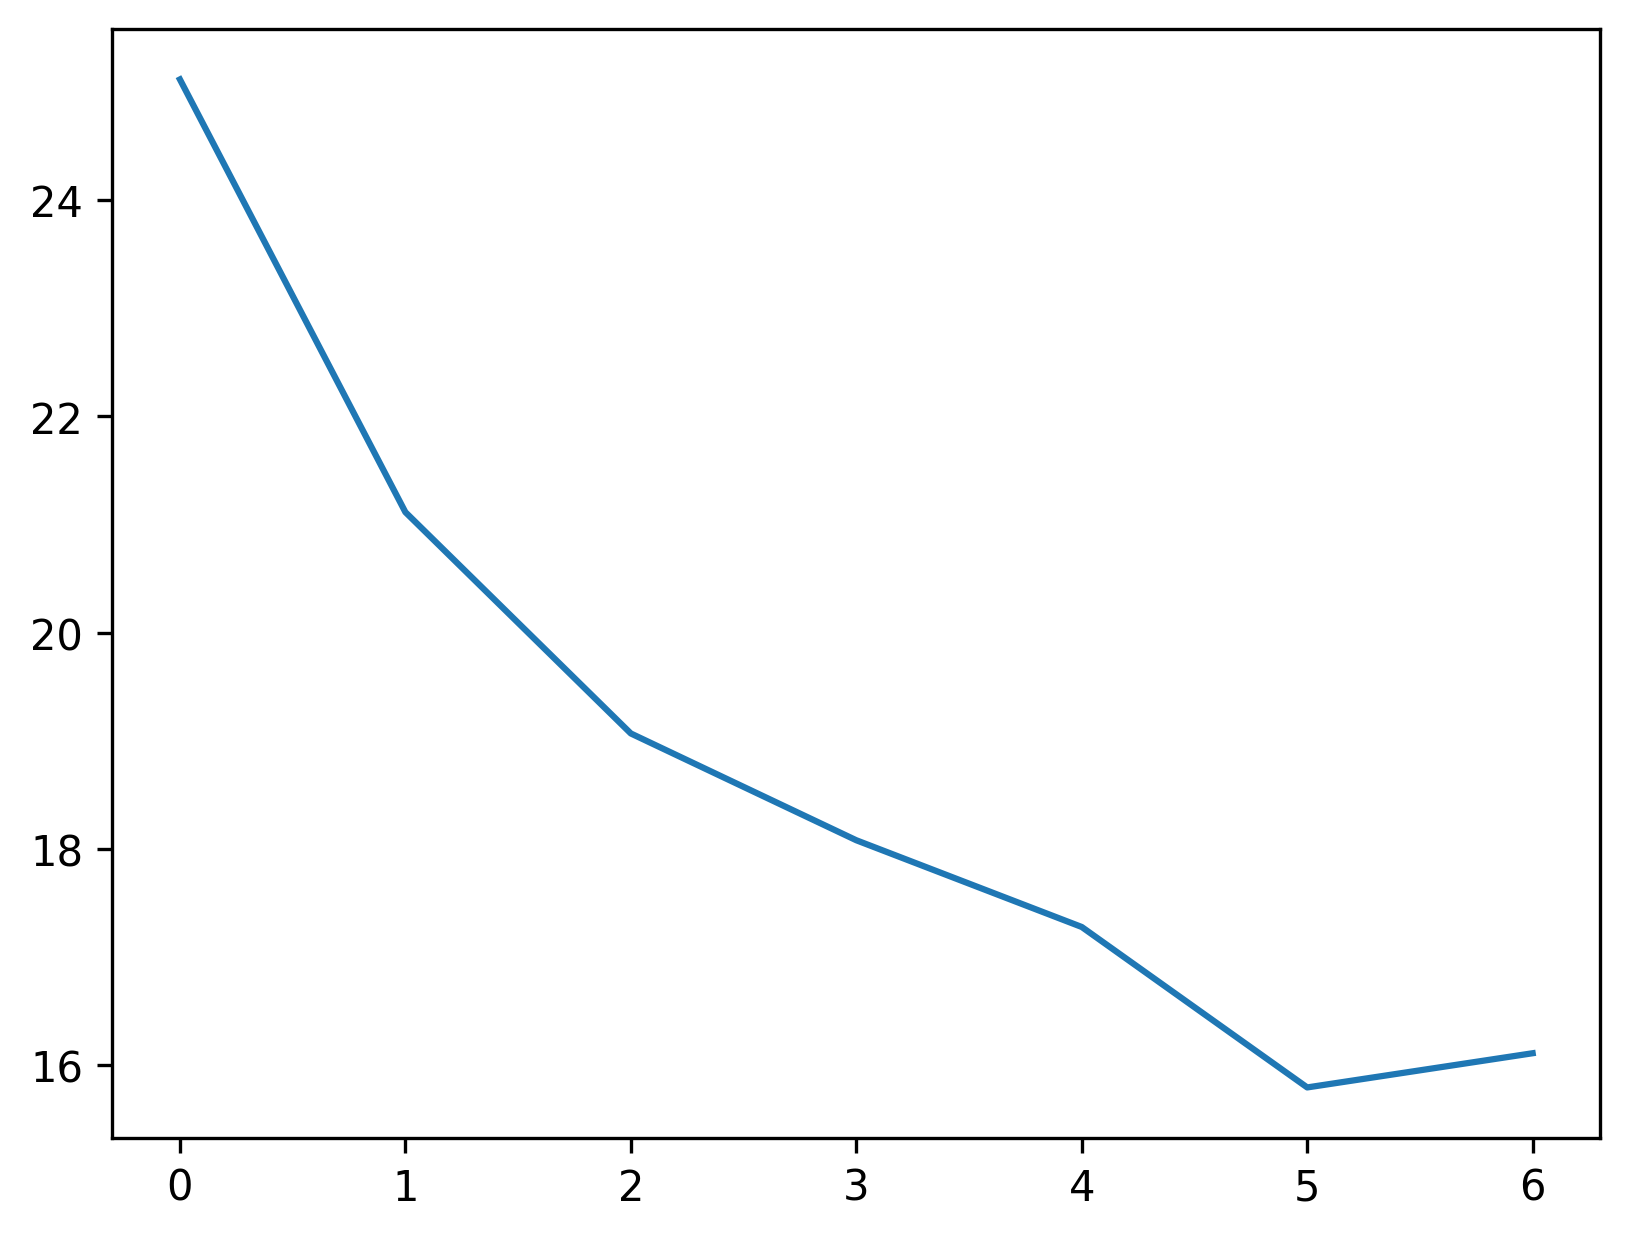

In [157]:
plot_hypervolume(lemoo._generation_history, ref_point=3*nadir)

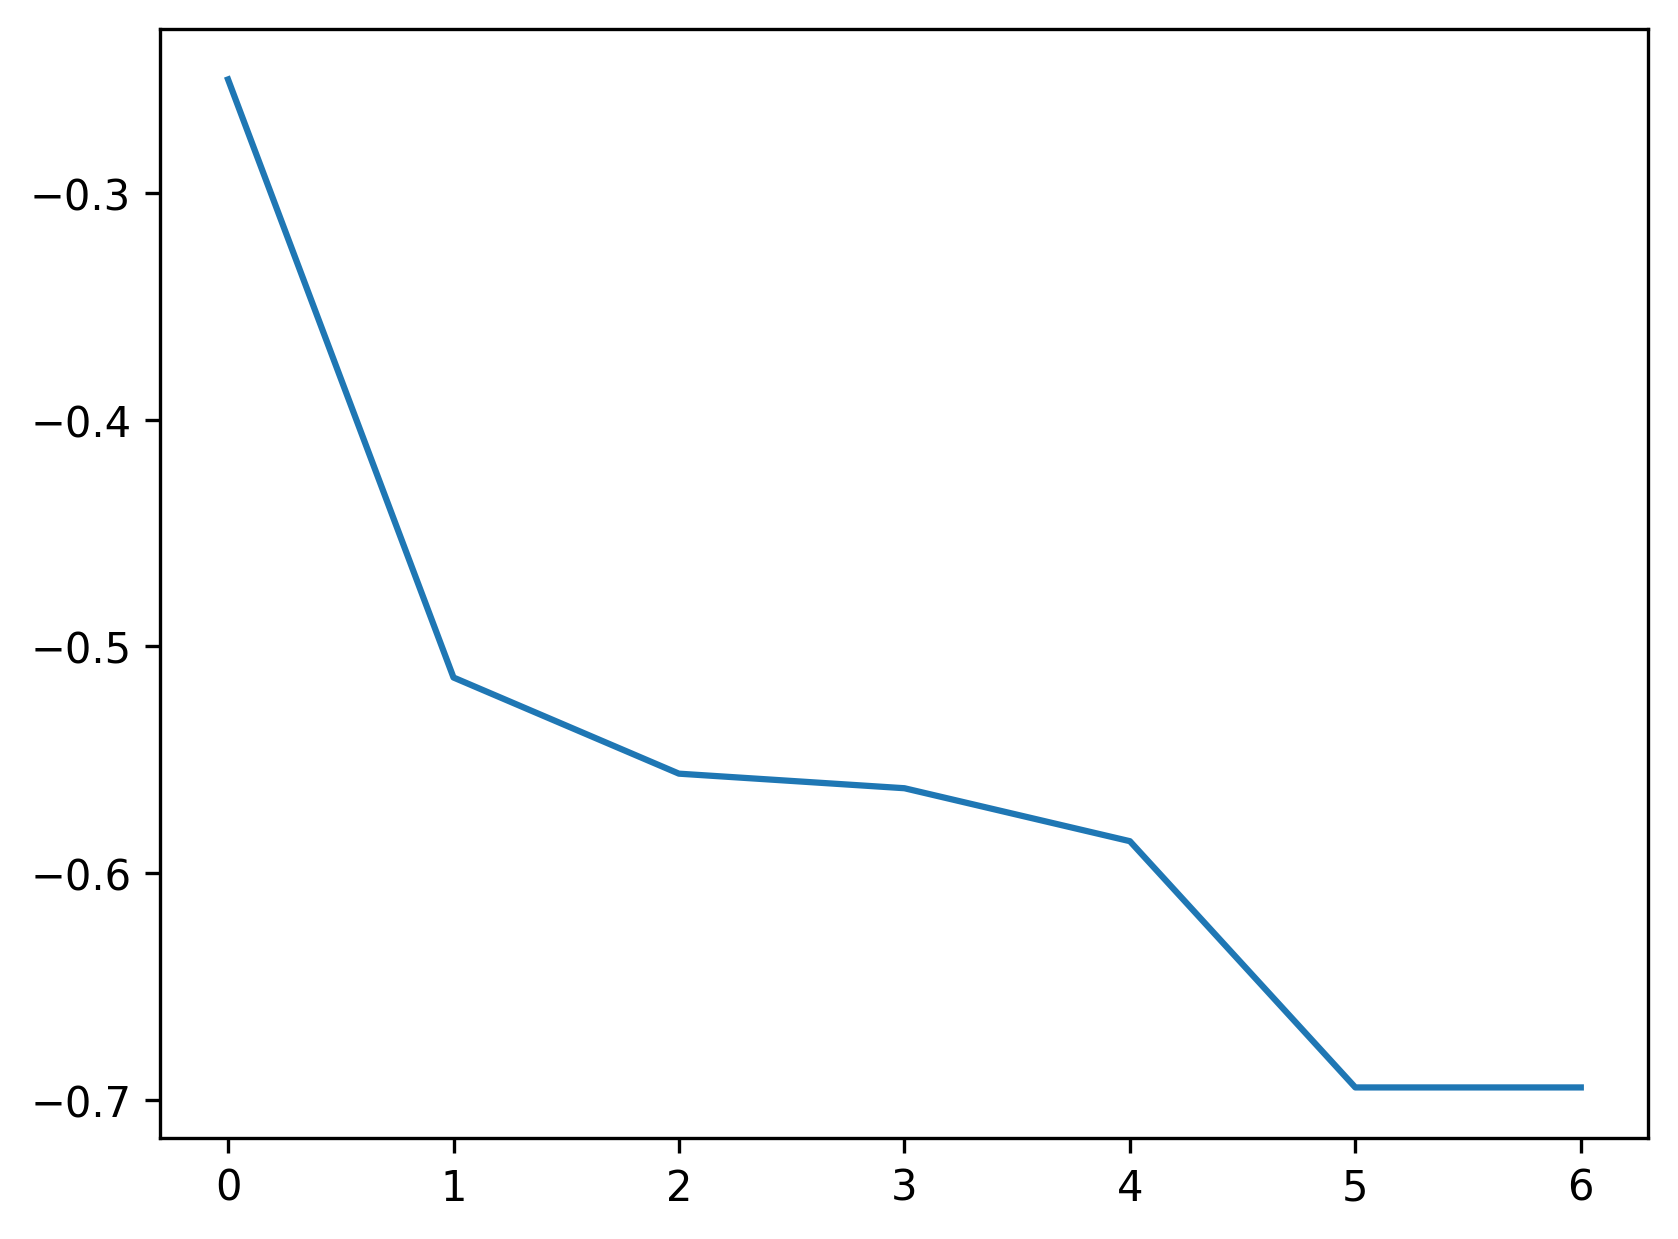

In [158]:
plot_best_fitnesses(lemoo._generation_history)

> ------------------------------
> BoostedRules:
> 	Rule → predicted probability (final prediction is weighted sum of all predictions)
> ------------------------------
  If X_1 < 0.635078449563122 and X_2 < 0.9767161324772531 → 0.58 (weight: 0.80)
  If X_1 < 0.9989479707012717 and X_1 > 0.004114265217405377 and X_2 > 0.01482208561559699 and X_3 < 0.9923951312227587 and X_4 < 0.9720963728590757 and X_4 > 0.00608456875240679 → 0.79 (weight: -0.62)
  If X_1 < 0.5896828283192243 and X_1 > 0.1999676174024451 → 0.38 (weight: 1.03)
  If X_1 > 0.004114265217405377 and X_4 < 0.9720963728590757 and X_5 < 0.9818685812476958 → 0.88 (weight: 0.45)
  If X_2 < 0.1294779474221522 → 0.17 (weight: 0.20)
  If X_1 < 0.6584879030916184 and X_4 > 0.2939192199323274 → 0.42 (weight: 0.58)
  If X_4 < 0.9720963728590757 and X_4 > 0.00608456875240679 → 0.92 (weight: 0.60)
  If X_1 > 0.004114265217405377 and X_2 > 0.01482208561559699 and X_4 < 0.9720963728590757 and X_5 < 0.9818685812476958 → 0.83 (weight: -0.88)

AttributeError: 'SlipperClassifier' object has no attribute 'tree_'

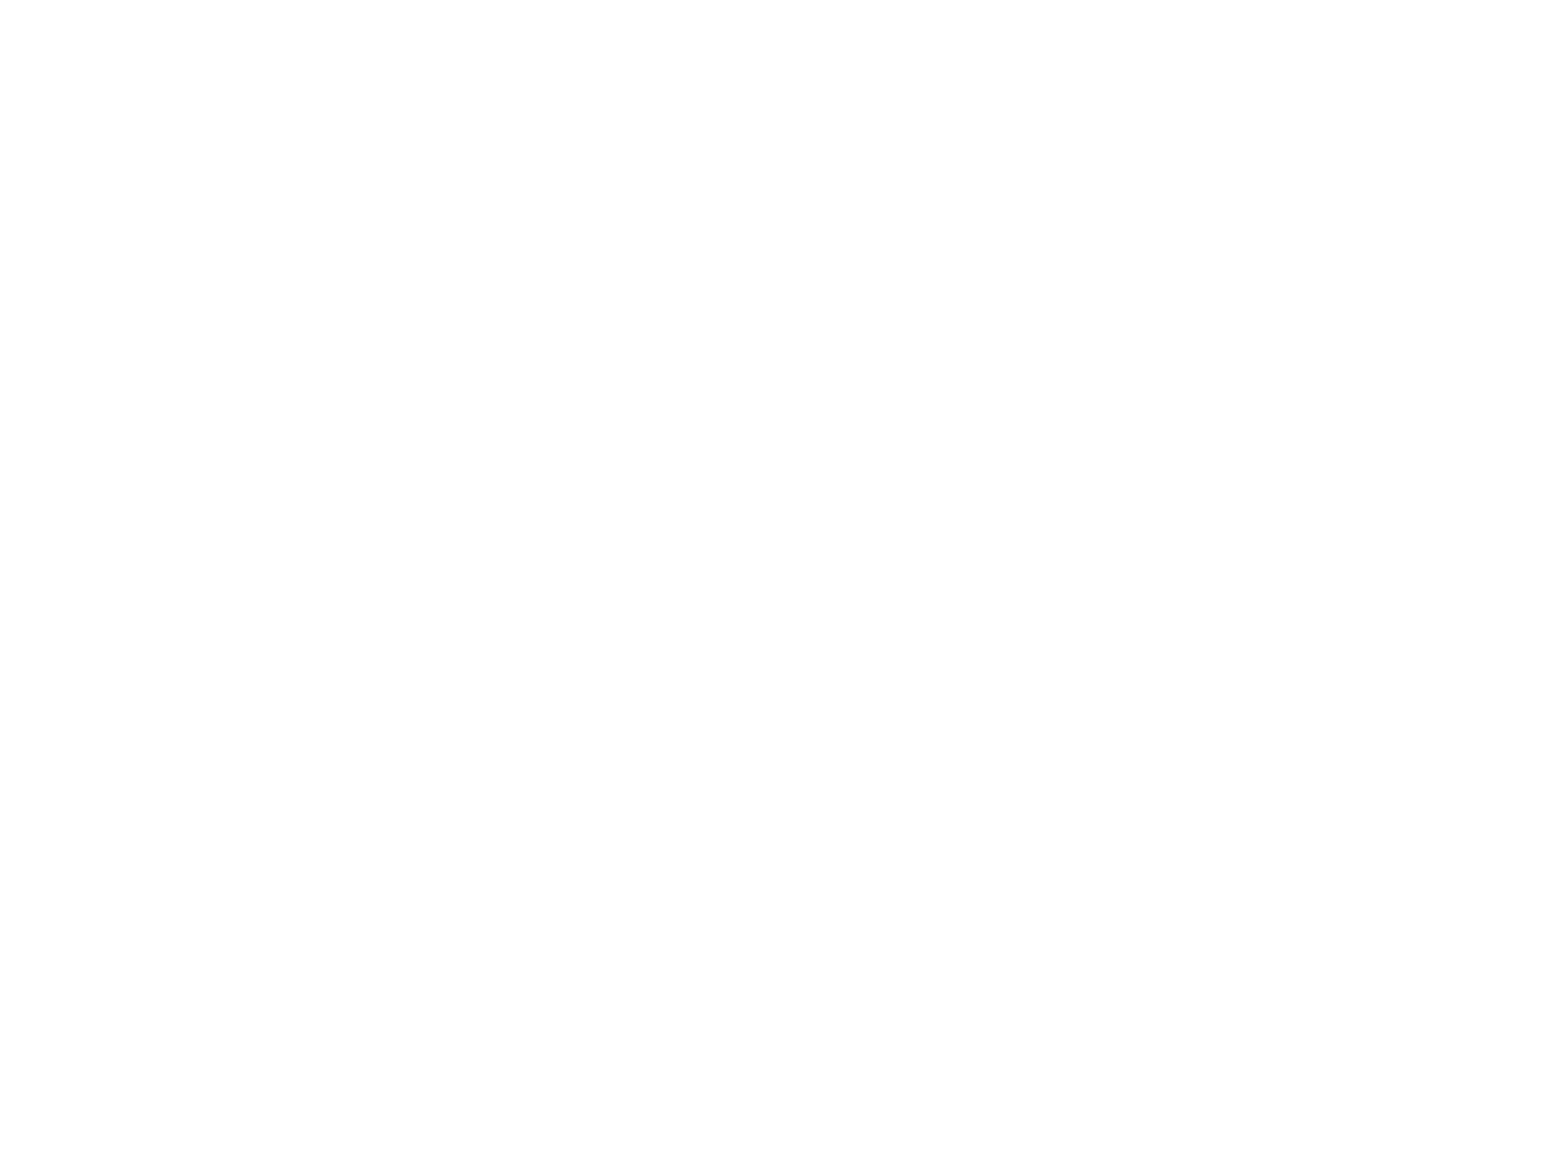

In [159]:
print(lemoo.current_ml_model)
tree.plot_tree(lemoo.current_ml_model)

In [ ]:
lemoo._generation_history[-1].individuals